# 신용카드 연체 사용자 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((26457, 20), (10000, 19))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  int64  
 18  begin_

# null값 제거

In [3]:
train.fillna('NAN', inplace=True)
test.fillna('NAN', inplace=True)

# Outlier Drop

In [5]:
# def crd_outlier(df=None, column=None, weight=1.5):
#     df = df[df['credit']==2][column]
#     p25 = np.percentile(df.values, 25)
#     p75 = np.percentile(df.values, 75)
#     IQR = (p75 - p25) * weight
#     low_limit  = p25 - IQR
#     high_limit = p75 + IQR
#     outlier_idx = df[(df < low_limit) | (df > high_limit)].index.values.tolist()
#     return outlier_idx
# outlier_idx = crd_outlier(df=train,column="income_total",weight=1.5)

In [6]:
# train.drop(outlier_idx, inplace=True)

# 파생변수 생성

In [7]:
edu_dict = {'Higher education':1, 'Secondary / secondary special':0, 'Incomplete higher':0, 'Lower secondary':0, 'Academic degree':0}
ft_dict = {'Married':1, 'Civil marriage':1, 'Separated':0, 'Single / not married':0, 'Widow':0}
house_dict = {'House / apartment':1,'Municipal apartment':0,'With parents':0,'Co-op apartment':0, 'Rented apartment':0, 'Office apartment':0}

In [8]:
train["T_edu_type"] = train["edu_type"].map(edu_dict)
train["T_family_type"] = train["family_type"].map(ft_dict)
train["T_house_type"] = train["house_type"].map(house_dict)
test["T_edu_type"] = test["edu_type"].map(edu_dict)
test["T_family_type"] = test["family_type"].map(ft_dict)
test["T_house_type"] = test["house_type"].map(house_dict)

----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
train["new_member"] = train["begin_month"].map(lambda x : 'new' if x>-6 else 'old')
test["new_member"] = test["begin_month"].map(lambda x : 'new' if x>-6 else 'old')

In [10]:
train["income_per_person"] = train["income_total"]//train["family_size"]
test["income_per_person"] = test["income_total"]//test["family_size"]

In [11]:
gen3_train_idx = train[(train["house_type"]=="With parents") & (train["child_num"]>0)].index
gen1_train_idx = train[(train["house_type"]!="With parents") & (train["child_num"]==0)].index

train["T_generation"]=2
train["T_generation"].loc[gen3_train_idx] = 3
train["T_generation"].loc[gen1_train_idx] = 1

gen3_test_idx = test[(test["house_type"]=="With parents") & (test["child_num"]>0)].index
gen1_test_idx = test[(test["house_type"]!="With parents") & (test["child_num"]==0)].index

test["T_generation"]=2
test["T_generation"].loc[gen3_test_idx] = 3
test["T_generation"].loc[gen1_test_idx] = 1

In [12]:
# train['car_reality'] = train['car'] + train['reality']
# test['car_reality'] = test['car'] + test['reality']

In [13]:
dic = {'NAN':6, 'Laborers':6, 'Managers':6, 'Sales staff':6, 'High skill tech staff':6, 'Core staff':6, 'Drivers':6,
       'Accountants':6, 'Private service staff':6, 'Cooking staff':6,
       "Waiters/barmen staff": 5, "Secretaries": 5,
       "Low-skill Laborers" :4, "Realty agents":4,
       "Cleaning staff":3,"Medicine staff":3,
       "HR staff":2, "IT staff":1, "Security staff":0}

train["T_occyp_type"] = train["occyp_type"].map(dic)
test["T_occyp_type"] = test["occyp_type"].map(dic)

--------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
train_duple = train.drop("credit", axis=1)
train_test = pd.concat([train_duple, test])
c = Counter(list(zip(train_test["DAYS_BIRTH"], train_test["gender"], train_test["child_num"], train_test["email"])))

train["T_card_num"] = list(zip(train["DAYS_BIRTH"], train["gender"], train["child_num"], train["email"]))
test["T_card_num"] = list(zip(test["DAYS_BIRTH"], test["gender"], test["child_num"], test["email"]))


train["T_card_num"] = train["T_card_num"].map(c)
test["T_card_num"] = test["T_card_num"].map(c)

# Drop columns

In [15]:
train['family_size']= train.drop(6.0)['family_size']
train['family_size']= train.drop(7.0)['family_size']
train['family_size']= train.drop(9.0)['family_size']
train['family_size']= train.drop(15.0)['family_size']
train['family_size']= train.drop(20.0)['family_size']

In [16]:
train['child_num']= train.drop(7)['child_num']
train['child_num']= train.drop(14)['child_num']
train['child_num']= train.drop(19)['child_num']

In [17]:
train.replace(365243, train["DAYS_EMPLOYED"].mean())['DAYS_EMPLOYED']

0       -4709.0
1       -1540.0
3       -2092.0
4       -2105.0
5       -4996.0
          ...  
26452   -1984.0
26453   -2475.0
26454   -2015.0
26455    -107.0
26456   -1013.0
Name: DAYS_EMPLOYED, Length: 25709, dtype: float64

# DAYS_BIRTH => AGE

In [18]:
# 나이로 변환
train["AGE"] = abs(train["DAYS_BIRTH"].apply(lambda x : x//365))
train["AGE"]

0        39
1        32
3        42
4        42
5        37
         ..
26452    34
26453    42
26454    28
26455    28
26456    54
Name: AGE, Length: 25709, dtype: int64

In [19]:
test["AGE"] = abs(test["DAYS_BIRTH"].apply(lambda x : x//365))
test["AGE"]

0       61
1       52
2       44
3       53
4       49
        ..
9995    51
9996    30
9997    58
9998    46
9999    26
Name: AGE, Length: 10000, dtype: int64

# DAYS_EMPLOYED => EMPLOYED

In [20]:
# 양수값은 모두 무직을 의미하므로 0으로 값 대체
train["EMPLOYED"] = train["DAYS_EMPLOYED"].map(lambda x: 0 if x>0 else x)
test["EMPLOYED"] = test["DAYS_EMPLOYED"].map(lambda x: 0 if x>0 else x)
# 일수 -> 년수로 변경
train["EMPLOYED"] = train["EMPLOYED"].map(lambda x: abs(x) // 365 if x<0 else x)
test["EMPLOYED"] = test["EMPLOYED"].map(lambda x: abs(x) // 365 if x<0 else x)

In [21]:
train["EMPLOYED"] = np.log1p(train["EMPLOYED"])
test["EMPLOYED"] = np.log1p(test["EMPLOYED"])

In [22]:
print("Skewness: {:.3f}".format(train["EMPLOYED"].skew()))

Skewness: -0.051


In [23]:
train.drop(['index','FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index','FLAG_MOBIL'], axis=1, inplace=True)

In [24]:
object_features = train.dtypes[train.dtypes == "object"].index.tolist()
object_features 

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'new_member']

# Normalization

<AxesSubplot:xlabel='income_total', ylabel='Density'>

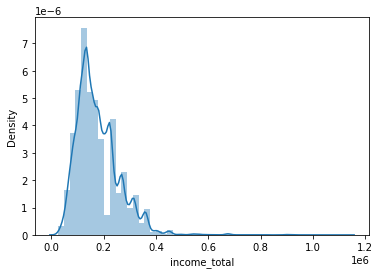

In [25]:
sns.distplot(train['income_total'])

<AxesSubplot:xlabel='income_total', ylabel='Density'>

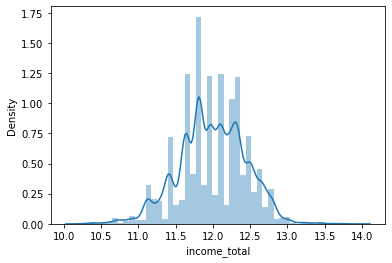

In [26]:
# 로그 변환
train['income_total'] = np.log1p(train['income_total'])
test['income_total'] = np.log1p(test['income_total'])
sns.distplot(train['income_total'])

# One-Hot Encoding

In [27]:
train = pd.get_dummies(data=train, columns=object_features)
train.shape

(25709, 67)

In [28]:
test = pd.get_dummies(data=test, columns=object_features)
test.shape

(10000, 66)

# Training

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical

In [30]:
X = train.drop(['credit'],axis=1)
y = train[['credit']]

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

random.seed(42)
xgb_models={}
xgb_outcomes = []

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    xgb=XGBClassifier(max_depth=18,
                      n_estimators=1000,
                      min_child_weight=0.5, 
                      min_child_samples=3, 
                      learning_rate =0.01,
                      colsample_bytree=0.3)
    evals = [(X_valid,y_valid)]
    xgb.fit(X_train, y_train,
               early_stopping_rounds=30, 
               eval_metric='mlogloss',
               eval_set=evals,
               verbose=100)
    
    predictions = xgb.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid['credit']), predictions)
    xgb_outcomes.append(logloss)

    xgb_models[fold]=xgb
    
    print(f'================================================================================\n\n')

====================================1============================================
[14:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.09388
[100]	validation_0-mlogloss:0.82813
[200]	validation_0-mlogloss:0.73716
[300]	validation_0-mlogloss:0.70145
[400]	validation_0-mlogloss:0.68762
[500]	validation_0-mlogloss:0.68280
[585]	validation_0-mlogloss:0.68265


====================================2============================================
[14:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples } might not be used.

  This may not be accurate due to

In [32]:
mean_outcome = np.mean(xgb_outcomes)
print(f"Mean:{mean_outcome}") #0.6959 #0.68

Mean:0.6975099206943641


In [33]:
submit = pd.read_csv('sample_submission.csv')

In [34]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += xgb_models[fold].predict_proba(test)/5

In [35]:
submit.to_csv('submit8.csv', index=False) 